c:\Users\liao\PycharmProjects\pythonProject1\AAA.Graduate work\MeasureV3\4cp34.47#3\../..\sagan\stellar_continuum.py:43: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


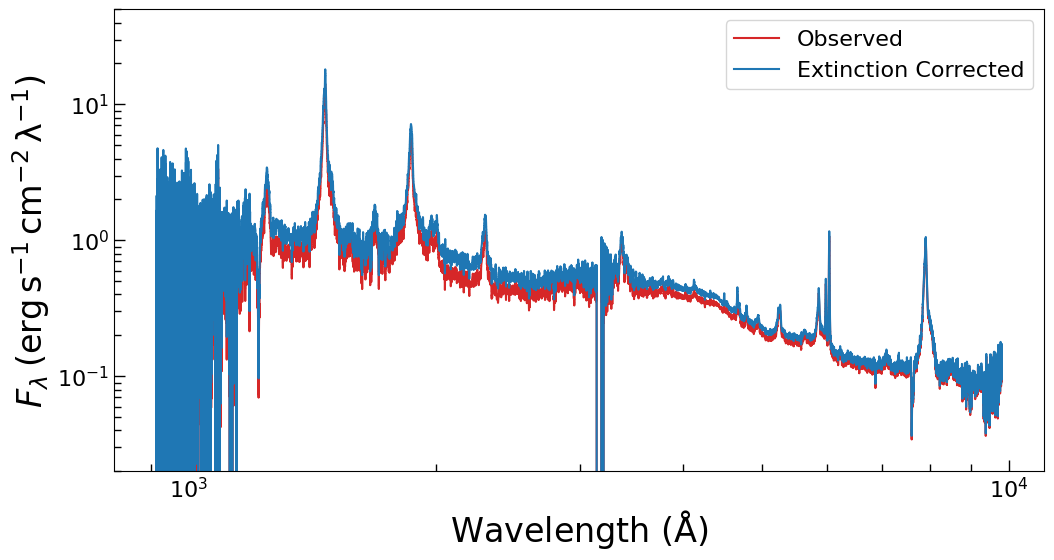

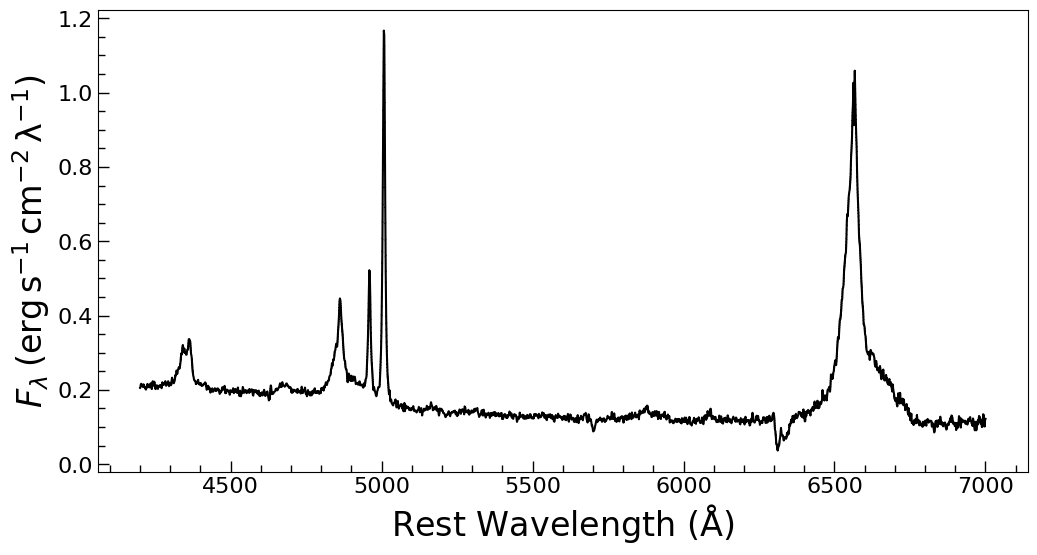

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('4cp34sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.101    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.2055 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

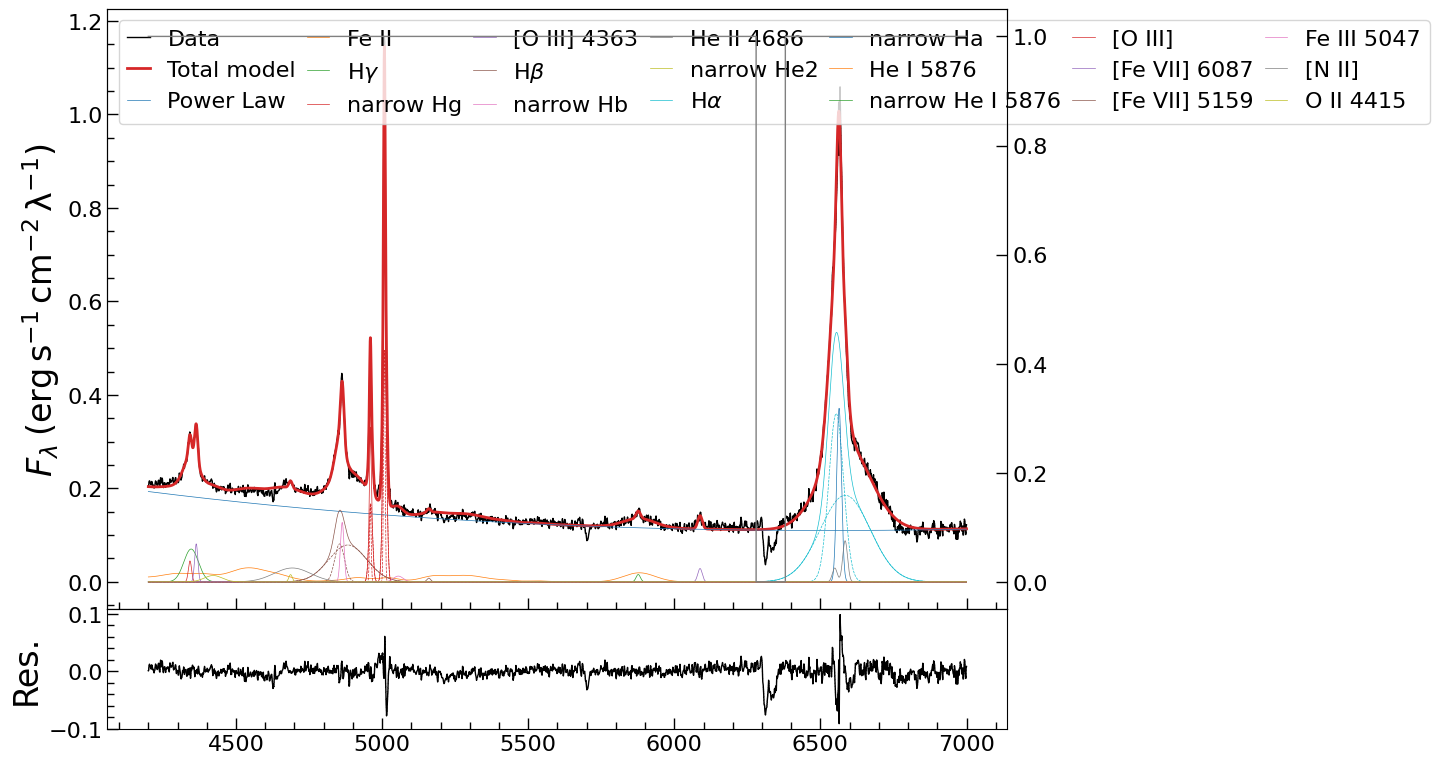

<PowerLaw1D(amplitude=0.07344631, x_0=6200., alpha=0.34242981, name='Power Law')>
<IronTemplate(amplitude=0.0214342, stddev=2499.157, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.03198445, dv_c=339.41820051, sigma_c=1730.12317541, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.02037772, dv=49.71687898, sigma=377.5613403, wavec=4341.785, name='narrow Hg')>
<Line_Gaussian(amplitude=0.03721868, dv=49.71687898, sigma=377.5613403, wavec=4363.21, name='[O III] 4363')>
<Line_MultiGauss(amp_c=0.0430214, dv_c=-500., sigma_c=1018.5306625, wavec=4862.721, amp_w0=0.97902092, dv_w0=1804.47819708, sigma_w0=4000., name='H$\\beta$')>
<Line_Gaussian(amplitude=0.06756192, dv=49.71687898, sigma=377.5613403, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.01503466, dv_c=500., sigma_c=4000., wavec=4686., name='He II 4686')>
<Line_Gaussian(amplitude=0.00784111, dv=49.71687898, sigma=377.5613403, wavec=4686., name='narrow He2')>
<Line_MultiGauss(amp_c=0.23602722, dv_c=-403.594622

In [2]:
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

pl = models.PowerLaw1D(amplitude=0.07344631, x_0=6200, alpha=0.34242981, fixed={'x_0': True,'amplitude':True,'alpha':True},name='Power Law')
iron = sagan.IronTemplate(amplitude=0.0214342, stddev=2499.157, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})
bounds = {'sigma_w0': (100, 4000),'sigma_c': (100, 4000), 'dv_c': (-500, 500)}

b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.23, dv_c=-406, sigma_c=1160, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.5159, dv_w0=1407, sigma_w0=3900)

b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.04, dv_c=-500, sigma_c=1020, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.9786, dv_w0=1783, sigma_w0=4000, bounds=bounds)
#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.13, dv_c=-280, sigma_c=1400, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])

#b_hg = sagan.Line_MultiGauss(n_components=2, amp_c=0.05, dv_c=400, sigma_c=1480, 
#                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'],
#                             amp_w0=0.1, dv_w0=350, sigma_w0=3500,bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.02519, dv_c=607, sigma_c=2388, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma']
                             )                             


'''
bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.46, dv_c=-230, sigma_c=1100, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.42, dv_w0=1250, sigma_w0=4200)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.1, dv_c=-470, sigma_c=1000, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.57, dv_w0=2500, sigma_w0=4000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.08, dv_c=520, sigma_c=1500, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
'''
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}

b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.0125, dv_c=270, sigma_c=2700, wavec=5875.624, name='He I 5876')
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.27, amp_c1=0.09, dv_c=48, sigma_c=380, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=-79, sigma_w0=163)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01464, dv_c=500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.058, amp_c1=0.02, dv_c=48, sigma_c=380,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

'''
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.024, dv_c=500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.023, dv_c=400, sigma_c=2000, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.36, amp_c1=0.12, dv_c=140, sigma_c=310, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=-135, sigma_w0=130, amp_w1=1, dv_w1=-300, sigma_w1=250)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.01, amp_c1=0.01,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.05, amp_c1=0.05, dv_c=-20, sigma_c=200,
#                                        wavec0=wave_dict['NII_6548'], wavec1=wave_dict['NII_6583'], name='[N II]')
'''

n_ha = sagan.Line_Gaussian(amplitude=0.244, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.0675, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.029, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.00797, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.0404, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he1_5876= sagan.Line_Gaussian(amplitude=0.01, wavec=5875.624, name=f'narrow He I 5876')
'''
n_ha = sagan.Line_Gaussian(amplitude=0.3, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.12, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.028, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.014, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.06, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
'''
#n_fe6=sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['FeVI_5176'], name=f'[Fe VI] 5176')
n_fe7_6087=sagan.Line_Gaussian(amplitude=0.018, wavec=wave_dict['FeVII_6087'], name=f'[Fe VII] 6087')

n_fe7_5159 = sagan.Line_Gaussian(amplitude=0.0045, wavec=wave_dict['FeVII_5159'], name=f'[Fe VII] 5159')
b_fe3_5047= sagan.Line_MultiGauss(n_components=1, amp_c=0.006, dv_c=500, sigma_c=1000, wavec=5047, name='Fe III 5047',bounds=bounds)
#b_he1_4713= sagan.Line_MultiGauss(n_components=1, amp_c=0.11, dv_c=500, sigma_c=1700, wavec=4713, name='He I 4713')
#b_he2_4543= sagan.Line_MultiGauss(n_components=1, amp_c=0.1, dv_c=-500, sigma_c=3330, wavec=4543, name='He II 4543')
#b_he1_4471= sagan.Line_MultiGauss(n_components=1, amp_c=0.2, dv_c=-300, sigma_c=3330, wavec=wave_dict['HeI_4471'], name='He I 4471')
b_o2_4415= sagan.Line_MultiGauss(n_components=1, amp_c=0.006, dv_c=500, sigma_c=2040, wavec=wave_dict['OII_4415'], name='O II 4415',bounds=bounds)


line_ha  =  b_ha + n_ha
line_he1 =  b_he1+n_he1_5876
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2
line_hg  =  b_hg + n_hg

'''
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked
'''

m_init = (pl + iron+ line_hg + n_o3_4363+line_hb+line_he2 +line_ha+line_he1+line_o3+n_fe7_6087 + n_fe7_5159+b_fe3_5047+line_n2+b_o2_4415 )*poly
#+ line_hg + n_o3_4363+line_hb+line_he2 +line_ha+line_he1+line_o3+n_fe7_6087 + n_fe7_5159+b_fe3_5047+line_n2+b_o2_4415


# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 3
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

#line_s2.sigma_c.tied = tie_narrow_sigma
#line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_fe7_6087,n_fe7_5159,n_he1_5876]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv


fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 6280) & (wave_use < 6380)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4770) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6890)

weights[fltr1] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

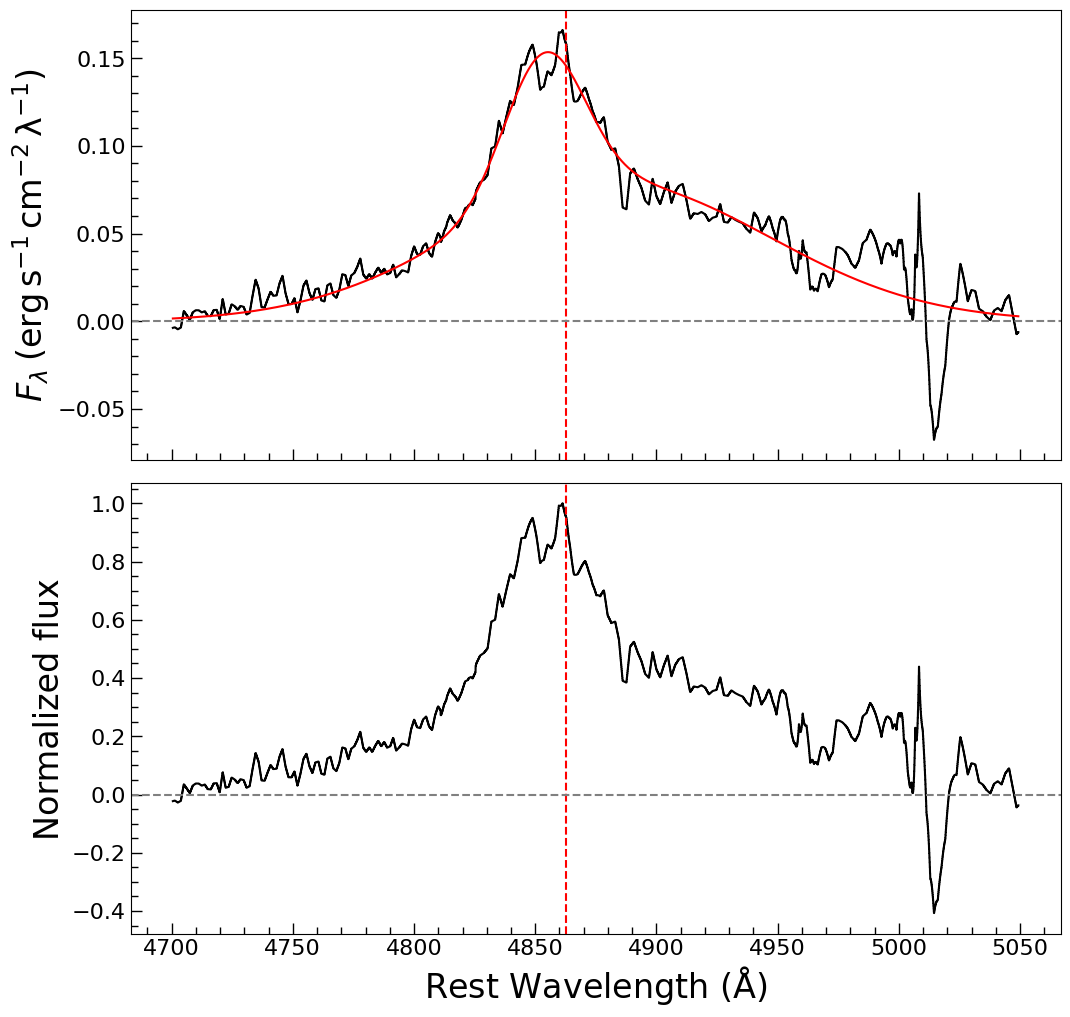

In [4]:
# H-beta

#m_multi = np.ones_like(wave_use)
m_multi=m_fit['multi'](wave_use)

m_hbeta = m_fit[label_dict['Hbeta']](wave_use) * m_multi
flux_hbeta = flux_use.copy()

# Correct the wavelength so that the narrow lines have central velocity of zero
dv_sys = m_fit['[O III]'].dv_c.value
wave_corr = wave_use * (1 - dv_sys / ls_km)
velc = (wave_corr / wave_dict['Hbeta'] - 1) * ls_km

# Cut the line profile to -5200 to 5200 km/s
fltr = (velc > -10000) & (velc < 11500)

for m in m_fit:
#    if m.name in [ label_dict['Hbeta']]:
    if m.name in ['multi', label_dict['Hbeta']]:
        continue
    flux_hbeta -= m(wave_use) * m_multi

wave_hb = wave_corr[fltr]
flux_hb = flux_hbeta[fltr]
model_hb = m_hbeta[fltr]

m_continuum=m_fit['Power Law'](wave_use)*m_multi#+ m_fit['Fe II'](wave_use)*m_multi
model_continuum=m_continuum[fltr]

flux_hb_norm = flux_hb / np.max(flux_hb)
ferr_hb_norm = np.zeros_like(flux_hb_norm) # Please note that the error is missing for now!

fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.05)

ax = axs[0]
ax.step(wave_hb, flux_hb, color='k')
ax.plot(wave_hb, model_hb, color='r')
ax.axvline(wave_dict['Hbeta'], ls='--', color='r')
ax.axhline(0, color='gray', linestyle='--')
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()

ax = axs[1]
ax.step(wave_hb, flux_hb_norm, color='k')
ax.axvline(wave_dict['Hbeta'], ls='--', color='r')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.minorticks_on()
ax.set_ylabel('Normalized flux', fontsize=24)
plt.show()

data = np.array([wave_hb, flux_hb_norm, ferr_hb_norm]).T
np.savetxt('data_hb.dat', data, fmt='%.6f')

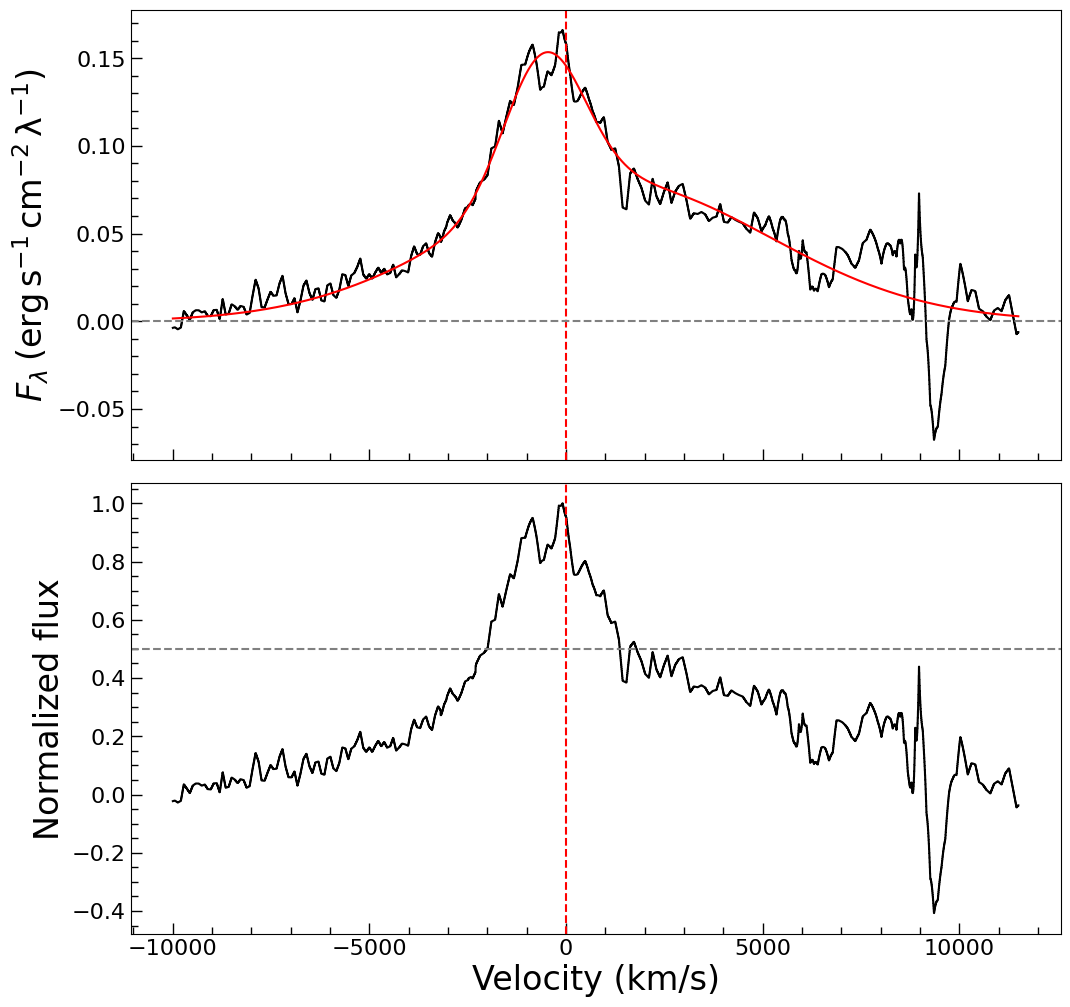

In [5]:
# H-beta

#m_multi = np.ones_like(wave_use)
m_multi=m_fit['multi'](wave_use)
m_hbeta = m_fit[label_dict['Hbeta']](wave_use) * m_multi
flux_hbeta = flux_use.copy()

# Correct the wavelength so that the narrow lines have central velocity of zero
dv_sys = m_fit['[O III]'].dv_c.value
wave_corr = wave_use * (1 - dv_sys / ls_km)
velc = (wave_corr / wave_dict['Hbeta'] - 1) * ls_km

# Cut the line profile to -5200 to 5200 km/s
fltr = (velc > -10000) & (velc < 11500)

for m in m_fit:
#    if m.name in [label_dict['Hbeta']]:
    if m.name in ['multi', label_dict['Hbeta']]:
        continue
    flux_hbeta -= m(wave_use) * m_multi

wave_hb = wave_corr[fltr]
flux_hb = flux_hbeta[fltr]
model_hb = m_hbeta[fltr]

flux_hb_norm = flux_hb / np.max(flux_hb)
ferr_hb_norm = np.zeros_like(flux_hb_norm) # Please note that the error is missing for now!
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.05)

ax = axs[0]
ax.step(velc[fltr], flux_hb, color='k')  # 修改横坐标为速度空间
ax.plot(velc[fltr], model_hb, color='r')  # 修改横坐标为速度空间
ax.axvline(0, ls='--', color='r')  # 中心速度为0
ax.axhline(0, color='gray', linestyle='--')
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()

ax = axs[1]
ax.step(velc[fltr], flux_hb_norm, color='k')  # 修改横坐标为速度空间
ax.axvline(0, ls='--', color='r')  # 中心速度为0
ax.axhline(0.5, color='gray', linestyle='--')
ax.set_xlabel(r'Velocity (km/s)', fontsize=24)  # 修改横坐标标签
ax.minorticks_on()
ax.set_ylabel('Normalized flux', fontsize=24)
plt.show()

In [6]:
# 计算Hb半高全宽 (FWHM)
half_max_hb = np.max(model_hb) / 2
indices_above_half_max = np.where(model_hb >= half_max_hb)[0]
fwhm_hb = velc[fltr][indices_above_half_max[-1]] - velc[fltr][indices_above_half_max[0]]

# 计算Hb等效宽度 (EW)
ew_hb = np.trapz((model_hb) /model_continuum, wave_hb)

print(f"FWHM_hb: {fwhm_hb:.2f} km/s")
print(f"Equivalent Width (EW_hb): {ew_hb:.2f} Angstrom")

FWHM_hb: 4591.75 km/s
Equivalent Width (EW_hb): 107.57 Angstrom


Equivalent Width (EW_FeII): 33.20 Angstrom
R_FeII: 0.31


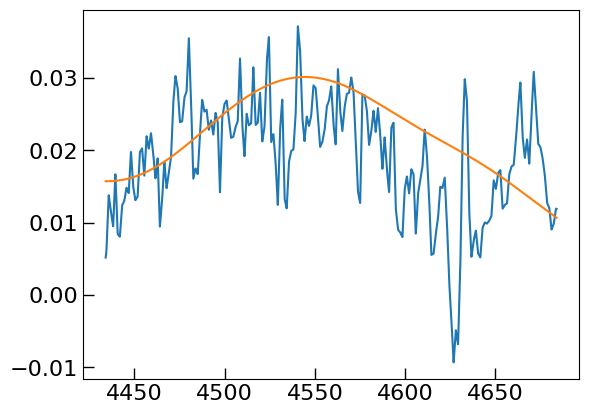

In [7]:
# FeII
import numpy as np
import matplotlib.pyplot as plt

fltr_fe = (wave_use > 4434) & (wave_use < 4684)
wave_fltr=wave_use[fltr_fe]
#m_multi = np.ones_like(wave_use)
m_multi = m_fit['multi'](wave_use)
flux_fe = flux_use.copy()

for m in m_fit:
#    if m.name in [ 'Fe II']:
    if m.name in ['multi', 'Fe II']:
        continue
    flux_fe -= m(wave_use) * m_multi
flux_FeII = flux_fe[fltr_fe]
a=np.array(wave_fltr)
b=np.array(flux_FeII)

m_fe = m_fit['Fe II'](wave_use) * m_multi
model_fe = m_fe[fltr_fe]
m_pl=m_fit['Power Law'](wave_use)*m_multi
model_pl=m_pl[fltr_fe]
plt.plot(a,b)
plt.plot(a,model_fe)
plt.show

# 计算FeII等效宽度 (EW)
ew_fe = np.trapz(model_fe/model_pl, wave_fltr) 
print(f"Equivalent Width (EW_FeII): {ew_fe:.2f} Angstrom")

R_FeII = ew_fe / ew_hb
print(f"R_FeII: {R_FeII:.2f}")

data = np.array([wave_fltr, flux_FeII]).T

np.savetxt('data_FeII.dat', data, fmt='%.6f')

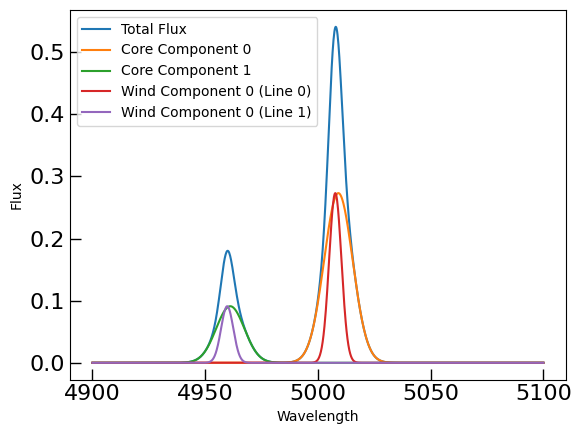

In [8]:
import numpy as np

# Constants
ls_km = 299792.458  # Speed of light in km/s
#m_fit['[O III]'].amp_c1.value
# Parameters
amp_c0 = m_fit['[O III]'].amp_c0.value
amp_c1 = m_fit['[O III]'].amp_c1.value
dv_c = m_fit['[O III]'].dv_c.value
sigma_c = m_fit['[O III]'].sigma_c.value
wavec0 = m_fit['[O III]'].wavec0.value
wavec1 = m_fit['[O III]'].wavec1.value
amp_w0 = m_fit['[O III]'].amp_w0.value
dv_w0 = m_fit['[O III]'].dv_w0.value
sigma_w0 = m_fit['[O III]'].sigma_w0.value
#amp_w1 = m_fit['[O III]'].amp_w1.value
#dv_w1 = m_fit['[O III]'].dv_w1.value
#sigma_w1 = m_fit['[O III]'].sigma_w1.value

# Wavelength array (example)
x = np.linspace(4900, 5100, 1000)

# Core components
v0 = (x - wavec0) / wavec0 * ls_km
v1 = (x - wavec1) / wavec1 * ls_km
flux_c0 = amp_c0 * np.exp(-0.5 * ((v0 - dv_c) / sigma_c)**2)
flux_c1 = amp_c1 * np.exp(-0.5 * ((v1 - dv_c) / sigma_c)**2)

# Wind components
flux_w0_0 = amp_c0 * amp_w0 * np.exp(-0.5 * ((v0 - dv_c - dv_w0) / sigma_w0)**2)
flux_w0_1 = amp_c1 * amp_w0 * np.exp(-0.5 * ((v1 - dv_c - dv_w0) / sigma_w0)**2)
#flux_w1_0 = amp_c0 * amp_w1 * np.exp(-0.5 * ((v0 - dv_c - dv_w1) / sigma_w1)**2)
#flux_w1_1 = amp_c1 * amp_w1 * np.exp(-0.5 * ((v1 - dv_c - dv_w1) / sigma_w1)**2)

# Total flux
flux_total = flux_c0 + flux_c1 + flux_w0_0 + flux_w0_1#+ flux_w1_0 + flux_w1_1

# Example plot (optional)
import matplotlib.pyplot as plt

plt.plot(x, flux_total, label='Total Flux')
plt.plot(x, flux_c0, label='Core Component 0')
plt.plot(x, flux_c1, label='Core Component 1')
plt.plot(x, flux_w0_0, label='Wind Component 0 (Line 0)')
plt.plot(x, flux_w0_1, label='Wind Component 0 (Line 1)')
#plt.plot(x, flux_w1_0, label='Wind Component 1 (Line 0)')
#plt.plot(x, flux_w1_1, label='Wind Component 1 (Line 1)')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

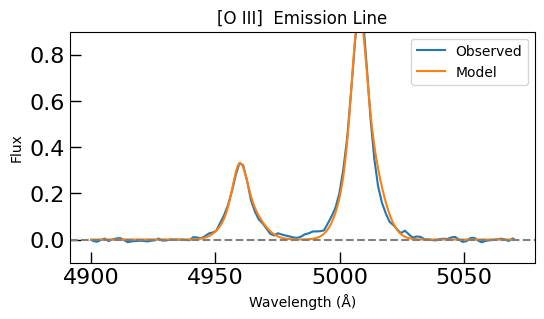

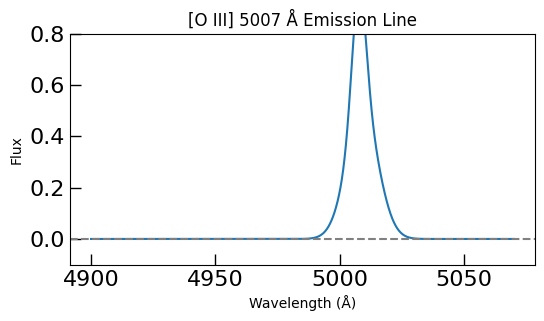

Equivalent Width (EW_OIII_5007): 78.35 Angstrom


In [9]:
#OIII_5007

import numpy as np
import matplotlib.pyplot as plt

fltr_o3 = (wave_use > 4900) & (wave_use < 5070)
wave_fltr=wave_use[fltr_o3]
#m_multi = np.ones_like(wave_use)
m_multi = m_fit['multi'](wave_use)
flux_o3 = flux_use.copy()

for m in m_fit:
#   if m.name in [ '[O III]']:
    if m.name in ['multi', '[O III]']:
        continue
    flux_o3 -= m(wave_use) * m_multi
flux_OIII = flux_o3[fltr_o3]

'''def gaussian_component(amp,wave_c,dv_c,sigma_c):
    wave_dv_c=wave_c*(dv_c/ls_km)
    wave_sigma_c=wave_c*(sigma_c/ls_km)
    return amp*np.exp(-0.5*((wave_c-wave_dv_c)/wave_sigma_c)**2)'''
#计算5007其余成分
def gaussian_component(amp, wave_c, dv_c, sigma_c, wave_use):
    # 计算波长偏移量和标准差
    wave_dv_c = wave_c * (dv_c / ls_km)
    wave_sigma_c = wave_c * (sigma_c / ls_km)
    return amp * np.exp(-0.5 * ((wave_use - wave_c - wave_dv_c) / wave_sigma_c) ** 2)

flux_n_o3_4958=m_multi*gaussian_component(m_fit['[O III]'].amp_c1.value ,wave_dict['OIII_4959'] ,m_fit['[O III]'].dv_c.value ,m_fit['[O III]'].sigma_c.value,wave_use)
flux_b_o3_4958=m_multi*gaussian_component((m_fit['[O III]'].amp_c1.value)*(m_fit['[O III]'].amp_w0.value) ,wave_dict['OIII_4959'] ,(m_fit['[O III]'].dv_c.value + m_fit['[O III]'].dv_w0.value) ,m_fit['[O III]'].sigma_w0.value ,wave_use)
#flux_b_o3_4958_2=m_multi*gaussian_component((m_fit['[O III]'].amp_c1.value)*(m_fit['[O III]'].amp_w1.value) ,wave_dict['OIII_4959'] ,(m_fit['[O III]'].dv_c.value + m_fit['[O III]'].dv_w1.value) ,m_fit['[O III]'].sigma_w1.value ,wave_use)
flux_b_o3_5007=m_multi*gaussian_component((m_fit['[O III]'].amp_c0.value)*(m_fit['[O III]'].amp_w0.value) ,wave_dict['OIII_5007'] ,(m_fit['[O III]'].dv_c.value + m_fit['[O III]'].dv_w0.value) ,m_fit['[O III]'].sigma_w0.value ,wave_use)
flux_n_o3_5007=m_multi*gaussian_component(m_fit['[O III]'].amp_c0.value ,wave_dict['OIII_5007'] ,m_fit['[O III]'].dv_c.value ,m_fit['[O III]'].sigma_c.value ,wave_use)

flux_o3_other=flux_n_o3_4958[fltr_o3]+flux_b_o3_4958[fltr_o3]#+flux_b_o3_4958_2[fltr_o3]#+flux_b_o3_5007[fltr_o3]
model_OIII_5007=flux_n_o3_5007[fltr_o3]+flux_b_o3_5007[fltr_o3]
m_continuum=m_fit['Power Law'](wave_use)*m_multi#+ m_fit['Fe II'](wave_use)*m_multi
model_continuum=m_continuum[fltr_o3]


#OIII全部量
a=np.array(wave_fltr)
b=np.array(flux_OIII)
m_o3 = m_fit['[O III]'](wave_use) * m_multi
model_o3 = m_o3[fltr_o3]
plt.figure(figsize=(6, 3))
plt.plot(a,b,label='Observed')
plt.plot(a,model_o3,label='Model')
plt.ylim(-0.1,0.9)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.axhline(0, color='gray', linestyle='--')
plt.title('[O III]  Emission Line')
plt.legend()
plt.show

#OIII_5007窄线_model
plt.figure(figsize=(6, 3))
plt.plot(wave_fltr,model_OIII_5007)
plt.ylim(-0.1,0.8)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.axhline(0, color='gray', linestyle='--')
plt.title('[O III] 5007 Å Emission Line')
plt.show()


# 计算OIII_5007等效宽度 (EW)
ew_o3_5007 = np.trapz(model_OIII_5007/model_continuum, wave_fltr) 
print(f"Equivalent Width (EW_OIII_5007): {ew_o3_5007:.2f} Angstrom")

data = np.array([wave_fltr, model_OIII_5007]).T
np.savetxt('data_OIII_5007.dat', data, fmt='%.6f')

In [10]:
file_path = '../resultsV3/resultsdataV3.txt'

# 读取现有数据
with open(file_path, 'r') as file:
    lines = file.readlines()
# 写入第3行数据
data=[f'{fwhm_hb:.8g}',f'{R_FeII:.8g}',f'{ew_o3_5007:.8g}',f'{np.log10(ew_o3_5007):.8g}',f'{ew_hb:.8g}']
lines[3] = ' '.join(data) + '\n'
# 写回文件
with open(file_path, 'w') as file:
    file.writelines(lines)